#Course work research

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install turicreate
!pip install lightfm

In [3]:
import pandas as pd
import turicreate as tc
from lightfm import LightFM, data
import numpy as np
import scipy

##Preprocess Movie Frame

In [4]:
movie_frame = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Course Work/movie.csv')

In [5]:
rating_frame = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Course Work/rating.csv')

In [6]:
popularity_frame = rating_frame[['userId', 'movieId']] \
                      .groupby('movieId')  \
                      .count()  \
                      .rename({'userId': 'user_id_count'}, axis='columns')  \
                      .sort_values('user_id_count', ascending=False)
popularity_frame.head()

,user_id_count
movieId,
296,67310
356,66172
318,63366
593,63299
480,59715


In [7]:
def popularity(column):
  if column < 4:
    return 'very low popularity'
  if column < 30:
    return 'low popularity'
  if column > 5000:
    return 'high popularity'
  return 'medium popularity'

In [8]:
popularity_frame['popularity'] = popularity_frame['user_id_count'].apply(popularity)

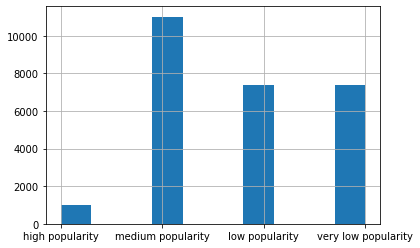

In [9]:
popularity_frame['popularity'].hist()

In [10]:
popoularity_one_hot = popularity_frame['popularity'].str.get_dummies()

In [11]:
max_id = max(movie_frame['movieId'])

In [12]:
movie_frame.set_index('movieId', inplace=True)

In [13]:
movie_frame = movie_frame.join(popoularity_one_hot, on='movieId', how='left')

In [14]:
movie_frame['year'] = movie_frame.title.str.extract('(\(\d\d\d\d\))',expand=False)
movie_frame['year'] = movie_frame.year.str.extract('(\d\d\d\d)',expand=False)

In [15]:
movie_frame['year'] = movie_frame['year'].fillna(1900)

In [16]:
movie_frame['decade'] = movie_frame['year'].apply(lambda x: str(int(x) // 10))
movie_frame['century'] = movie_frame['year'].apply(lambda x: str(int(x) // 100))

In [17]:
movie_frame = movie_frame.join(movie_frame['decade'].str.get_dummies(), how='left')
movie_frame = movie_frame.join(movie_frame['century'].str.get_dummies(), how='left')

In [18]:
movie_frame.drop(['year', 'decade', 'century'], axis=1, inplace=True)

In [19]:
movie_frame = movie_frame.join(movie_frame['genres'].str.get_dummies(), how='left')

In [20]:
movie_frame.drop(['title', 'genres', '(no genres listed)'], axis=1, inplace=True)

In [21]:
movie_frame.head()

,high popularity,low popularity,medium popularity,very low popularity,189,190,191,192,193,194,195,196,197,198,199,200,201,18,19,20,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
movie_frame.shape

(27278, 39)

In [23]:
max_id

131262

In [24]:
dummy_frame = pd.DataFrame(data=np.arange(max_id + 1), columns=['movieId']).set_index('movieId')
dummy_frame

""
movieId
0
1
2
3
4
...
131258
131259
131260


In [25]:
movie_frame = movie_frame.join(dummy_frame, how='right', on='movieId').set_index('movieId').fillna(0)

## LightFM

In [59]:
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

In [30]:
user_movie_frame = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Course Work/rating.csv')

In [31]:
user_movie_frame.drop('timestamp', axis=1, inplace=True)

In [32]:
user_movie_frame.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [33]:
users_count = max(user_movie_frame['userId']) + 1
movies_count = max(user_movie_frame['movieId']) + 1
users_count, movies_count

(138494, 131263)

In [34]:
def encode_binary(x):
    return 1 if x > 4 else -1

user_movie_frame['rating'] = user_movie_frame['rating'].apply(encode_binary)

In [35]:
user_movie_frame.head(5)

,userId,movieId,rating
0,1,2,-1
1,1,29,-1
2,1,32,-1
3,1,47,-1
4,1,50,-1


In [36]:
training_frame, test_frame = train_test_split(user_movie_frame, test_size=0.2, random_state=125)

In [37]:
rating_frame_sparse = coo_matrix((training_frame['rating'], (training_frame['userId'], training_frame['movieId'])), shape=(users_count, movies_count))

In [38]:
rating_frame_sparse_test = coo_matrix((test_frame['rating'], (test_frame['userId'], test_frame['movieId'])), shape=(users_count, movies_count))

In [39]:
rating_frame_sparse

<138494x131263 sparse matrix of type '<class 'numpy.int64'>'
	with 16000210 stored elements in COOrdinate format>

In [40]:
movies_features_sparsed = scipy.sparse.csr_matrix(movie_frame.values)

In [41]:
movies_features_sparsed

<131263x39 sparse matrix of type '<class 'numpy.float64'>'
	with 135460 stored elements in Compressed Sparse Row format>

In [42]:
model = LightFM(random_state=125)
model.fit(rating_frame_sparse, item_features=movies_features_sparsed)

In [53]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
def logloss(y_true, y_pred):
    labels = [0 if i < 0 else 1 for i in y_true]
    return log_loss(labels, sigmoid(y_pred))

logloss_scorer = make_scorer(
    logloss,
    greater_is_better=False
)

##Hyperparams tuning

In [63]:
no_components_range = np.arange(5, 51, 5)

y_true = test_frame['rating']

log_loss_no_comp = []

for no_components in no_components_range:
    print(f'no_components = {no_components}')
    model = LightFM(random_state=125, no_components=no_components)
    model.fit(rating_frame_sparse, item_features=movies_features_sparsed)
    predictions = model.predict(user_ids=np.array(test_frame['userId']), 
                                item_ids=np.array(test_frame['movieId']), 
                                item_features=movies_features_sparsed)
    log_loss_no_comp.append(logloss(y_true, predictions))
    print(f'logloss = {log_loss_no_comp[-1]}')

no_components = 5
logloss = 0.448764324593287
no_components = 10
logloss = 0.4437708371332553
no_components = 15
logloss = 0.44311930984799536
no_components = 20
logloss = 0.4424844638918465
no_components = 25
logloss = 0.44222809648421035
no_components = 30
logloss = 0.4420766015299164
no_components = 35
logloss = 0.44189542487913536
no_components = 40
logloss = 0.4418776275925455
no_components = 45
logloss = 0.4418152510082015
no_components = 50
logloss = 0.4419233001011425


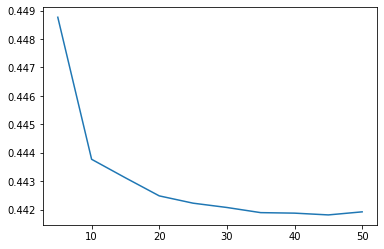

In [64]:
plt.plot(no_components_range, log_loss_no_comp)

In [65]:
best_no_comp = no_components_range[np.argmin(log_loss_no_comp)]
best_no_comp

45

In [67]:
user_alphas = np.logspace(-8, 0, 10)

y_true = test_frame['rating']

log_loss_alphas = []

for user_alpha in user_alphas:
    print(f'user_alpha = {user_alpha}')
    model = LightFM(random_state=125, 
                    no_components=best_no_comp, 
                    user_alpha=user_alpha)
    model.fit(rating_frame_sparse, item_features=movies_features_sparsed)
    predictions = model.predict(user_ids=np.array(test_frame['userId']), 
                                item_ids=np.array(test_frame['movieId']), 
                                item_features=movies_features_sparsed)
    log_loss_alphas.append(logloss(y_true, predictions))
    print(f'logloss = {log_loss_alphas[-1]}')

user_alpha = 1e-08
logloss = 0.4418152611841543
user_alpha = 7.742636826811277e-08
logloss = 0.4418333162468715
user_alpha = 5.994842503189409e-07
logloss = 0.4429106024140067
user_alpha = 4.641588833612773e-06
logloss = 0.47172391982153955
user_alpha = 3.5938136638046256e-05
logloss = 0.5586982145472033
user_alpha = 0.0002782559402207126
logloss = 2.274839710540897
user_alpha = 0.002154434690031882
logloss = 0.6822083922387127
user_alpha = 0.016681005372000558
logloss = 0.5205866494726719
user_alpha = 0.12915496650148828
logloss = 0.5097876184103205
user_alpha = 1.0
logloss = 0.509545827199002


(0.4, 0.6)

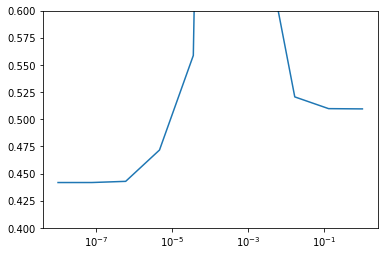

In [71]:
plt.plot(user_alphas, log_loss_alphas)
plt.xscale('log')
plt.ylim([0.4, 0.6])

In [72]:
best_alpha = user_alphas[np.argmin(log_loss_alphas)]
best_alpha

1e-08

##Final predictions

In [75]:
y_true = test_frame['rating']
model = LightFM(random_state=125, 
                no_components=best_no_comp, 
                user_alpha=best_alpha,
                learning_schedule='adagrad')
model.fit(rating_frame_sparse, item_features=movies_features_sparsed)
predictions = model.predict(user_ids=np.array(test_frame['userId']), 
                            item_ids=np.array(test_frame['movieId']), 
                            item_features=movies_features_sparsed)

In [76]:
logloss(y_true, predictions)

0.4418152611841543